# Toy Network Analysis with Cobra

## Contents
* Flux Balance Analysis (FBA)
* Identifying Essential and Active Reactions
* Flux Variability Analysis (FVA)

In this notebook we analyse a simple toy metabolic network to practice the use of the cobra library. The toy network is depicted below:

![toy-nw](data/Toy_network.png)

## Loading Libraries and Implementing the Model

In [2]:
# importing packages and required objects
import cobra
from matplotlib import pyplot as plt
import numpy as np

For better overview in this notebook we implement the model in the python file **toy_model.py**, where we also save it in SBML format. We read in the model with the following call:

In [5]:
# run the script
!python toy_model.py

model = cobra.io.read_sbml_model('data/ToyModel.xml')

No objective coefficients in model. Unclear what should be optimized


For now the model has no objective function. To define one, we need to find the reaction ID of possible outputs we want to opimize later on in the analysis. We print the number of components such as metabolites and reactions of the model that we loaded:

In [11]:
# Check that we have the expected amount of reactions and metabolites.
print('Model information')
print("---------")
print(f"{len(model.reactions)} reactions")
print(f"{len(model.metabolites)} metabolites")
print(f"{len(model.genes)} genes") # no genes implemented

Model information
---------
21 reactions
16 metabolites
0 genes


To define an objective we print all reactions:

In [9]:
# Print the Reactions with IDs and bounds
print("Reactions")
print("---------")
for x in model.reactions:
    print(f"{x.id} : {x.reaction} / {x.lower_bound} / {x.upper_bound}")

# Print the Metabolites with IDs
# print("Metabolites")
# print("-----------")
# for x in model.metabolites:
#     print(f"{x.id} : {x.compartment}")

Reactions
---------
R1 : X_c --> X_e / 0.0 / 1000.0
R2 : A_e --> E_c / 0.0 / 1000.0
R3 : E_c --> F_c / 0.0 / 1000.0
R4 : E_c <=> G_c / -1000.0 / 1000.0
R5 : F_c <=> G_c / -1000.0 / 1000.0
R6 : F_c <=> 2.0 I_c / -1000.0 / 1000.0
R7 : B_e --> H_c / 0.0 / 1000.0
R8 : I_c --> J_c / 0.0 / 1000.0
R9 : J_c --> O_c / 0.0 / 1000.0
R10 : C_e --> L_c / 0.0 / 1000.0
R11 : L_c --> M_c + N_c / 0.0 / 1000.0
R12 : 1.5 N_c <=> G_c / -1000.0 / 1000.0
R13 : M_c --> M_e / 0.0 / 1000.0
R14 : G_c + O_c --> X_c / 0.0 / 1000.0
R15 : H_c <=> I_c / -1000.0 / 1000.0
R16 : B_e --> 0.5 I_c / 0.0 / 1000.0
R17 : A_e <=>  / -10.0 / 1000.0
R18 : M_e -->  / 0.0 / 1000.0
R19 : C_e -->  / 0.0 / 1000.0
R20 : B_e -->  / 0.0 / 1000.0
R21 : X_e -->  / 0.0 / 1000.0


## Flux Balance Analysis (FBA)

We need Flux Balance Analysis is a powerful approach to analyse and predict the behaviour metabolic behaviour within organisms. Each reaction is seen as a "flux" of the system, whereas the word "balance" refers to the system being in steady state. We use this steady state to optimize a single "flux" or output in this example.

As we see in the graph synthesis rate of X_e depends on the rate of substrate uptake, which in this case is going to be only A_e. Increasing the uptake rate of A_e would result in a proportional increase in the synthesis of X_e.
We perform FBA to get the maximal production of X_e when A_e is imported into the cell (“taken up”) at a maximal rate of 10 mmol/gDW/hr. In this analysis we choose to maximize the output of X_e of the cell, thus we choose "R1" to be our objective with this call:

In [10]:
# Set the objective:
model.objective = "R1"
# Save the updated model:
# We can save the updated model into SBML format if we need:
# cobra.io.write_sbml_model(model, 'ToyModel.xml')

To ensure that only A_e is imported, we cut off all other import of metabolites by setting the lower bound to zero, i.e. make the reverse reaction impossible:

In [12]:
# lower_bound controls the reverse reaction -> we set all but R1 to 0: nothing gets in but A
for i in [18, 19, 20, 21]:
    model.reactions.get_by_id("R"+str(i)).lower_bound = 0.

To explore the relationship of A_e and X_e in this network we increase the import of A_e stepwise (more negative -> more import). We see that the relationship is linear, thus more import of A_e means proportionally more output of X_e.

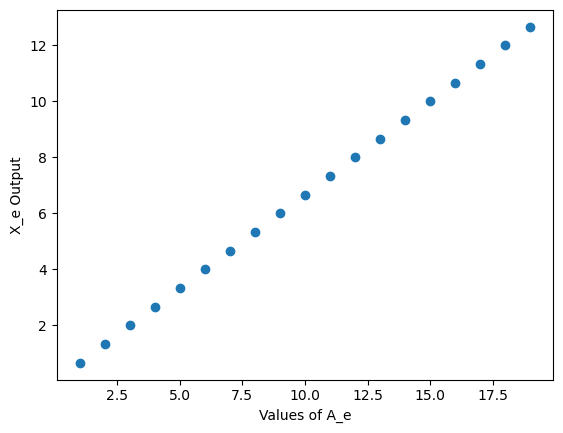

In [21]:
lows = np.arange(-1, -20, -1)
opts = []
for l in lows:
    model.reactions.get_by_id("R17").lower_bound = l
    fba_solution = model.optimize()
    # Uncomment the lines to view the model summaries:
    # print(fba_solution.objective_value)
    # print(model.summary())
    opts.append(fba_solution.objective_value)

plt.scatter(-lows, opts)
plt.xlabel("Values of A_e")
plt.ylabel("X_e Output")
plt.show()

## Identifying Essential Reactions

A reaction is essential for the synthesis of a molecule from a specific substrate if its removal makes the synthesis of that molecule from the substrate impossible. As an example, consider the reactions involved in the synthesis of metabolite O from substrate B_e in figure 1. Synthesis of O from B_e requires reactions R8 and R9, but not R7 and R15, as these can be replaced by R16. If we were to delete either R8 or R9, it would be impossible to synthesize O from B_e. We therefore say that reactions R8 and R9 are essential for the production of O from substrate B_e.

With the function `single_reaction_deletion` we can identify essential reactions:

In [22]:
if __name__ == "__main__":
    from cobra.flux_analysis import single_reaction_deletion
    # we call single reaction deletion
    deletion_results = single_reaction_deletion(model)
    # lower_bound controls the reverse reaction -> we set all but A to 0: nothing gets in but A
    print("Reactions that are essential are:")
    mask = deletion_results["growth"].round(3) == 0 # important as the algorithm output 4*10^-15 instead of 0.
    print(deletion_results[mask]["ids"])

Reaction that are essential are:
0      {R9}
2      {R2}
5     {R17}
8     {R14}
12     {R1}
17     {R8}
18    {R21}
20     {R6}
Name: ids, dtype: object


Instead of using `single_reaction_deletion` we can apply FBA on metabolic where we cut single reactions to explore its affect on the model. This code basically explains what happens inside cobras helper function used above:

In [23]:
# first define reaction IDS to test:
Rs_totest = [3, 6]
model.reactions.get_by_id("R17").lower_bound = -10.
for i in Rs_totest:
    # set interest to 0 flux
    model.reactions.get_by_id(f"R{i}").upper_bound = 0.
    fba_solution = model.optimize()
    # print(fba_solution.objective_value)
    objective = fba_solution.objective_value
    # if outflux is 0 we know that
    if round(objective, 3) == 0:
        print(f"Reaction R{i} is an essential reaction, because the FBA is {objective}")
    else:
        print(f"Reaction R{i} is NOT an essential reaction, because the FBA is {objective}")
    # reset
    model.reactions.get_by_id(f"R{i}").upper_bound = 1000.

Reaction R3 is NOT an essential reaction, because the FBA is 6.666666666666666
Reaction R6 is an essential reaction, because the FBA is 0.0


## Identifying Active Reactions

Active reactions are reactions that have a non-zero metabolic flux, that is, reactions proceeding at a rate different from zero. It is NOT the upper and/or lower bound of a reaction that determines whether it is active, but the effective flux of the reaction in the FBA solution. Therefore, we can only know whether a reaction is active or not after performing FBA.
This approach is similar to the detection of essential reactions, except that we're not cutting of input. We can directly extract the fluxes from the optimized model object with the attribute `fluxes`:

In [24]:
fluxes = model.optimize().fluxes
print("The active reactions are:")
print(list(fluxes[fluxes.round(3) == 0].index))

The active reactions are:
['R3', 'R7', 'R10', 'R11', 'R12', 'R13', 'R15', 'R16', 'R18', 'R19', 'R20']


## Flux Variability Analysis (FVA)

FBA solutions are rarely unique. For example, think about the active pathway we found earlier that produces X_e from A_e. Is this the only possible solution that maximizes production of X_e?
In general, we find that at least some reactions can take a whole range of fluxes without affecting the flux through the objective function. Metabolic networks are thus “flux variable”, and FVA can provide some insights into the extent of the network’s flux variability. FVA computes the minimum and maximum value of the flux through a reaction while keeping a given objective, such as biomass synthesis, unchanged, thus estimating the range of possible fluxes through a reaction (the reaction’s flux variability).

We perform FVA and drop the reactions that don't vary by filtering for zero values:

In [39]:
if __name__ == "__main__":
    # fva
    fva_solution = cobra.flux_analysis.flux_variability_analysis(model)
    print("The FVA results in:")
    # filter
    mask = np.logical_or(fva_solution['minimum'] != 0, fva_solution['maximum'] != 0).to_numpy()
    print(fva_solution[mask])

The FVA results in:
        minimum      maximum
R1     6.666667     6.666667
R2    10.000000    10.000000
R3     0.000000  1000.000000
R4  -990.000000    10.000000
R5    -3.333333   996.666667
R6     3.333333     3.333333
R8     6.666667     6.666667
R9     6.666667     6.666667
R14    6.666667     6.666667
R17  -10.000000   -10.000000
R21    6.666667     6.666667


Thank you for checking out my simple analysis, I hope you could learn something.